In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

In [29]:
df=pd.read_csv(r"C:\Users\DELL\Downloads\CAR DETAILS FROM CAR DEKHO.csv",encoding='latin1')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [30]:
df.shape

(4340, 8)

In [31]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner'],
      dtype='object')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [33]:
df.describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


In [34]:
df.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

In [35]:
duplicates=df.duplicated().sum()
print(duplicates)

763


In [36]:
df=df.drop_duplicates()

In [37]:
df.shape

(3577, 8)

In [38]:
REFERENCE_YEAR = 2025
df['car_age'] = REFERENCE_YEAR - df['year']
df = df[df['selling_price'] > 1000]

In [39]:
df = df[df['km_driven'] >= 0]
km_cut = df['km_driven'].quantile(0.995)
df = df[df['km_driven'] <= km_cut]

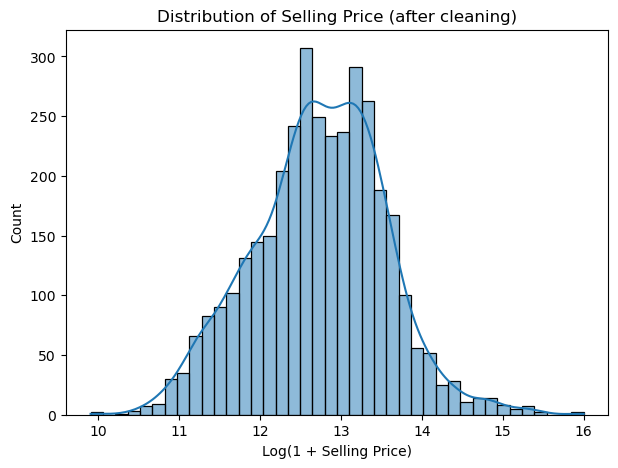

In [63]:
plt.figure(figsize=(7,5)) 
sns.histplot(np.log1p(df['selling_price']), bins=40, kde=True) 
plt.xlabel("Log(1 + Selling Price)")
plt.title("Distribution of Selling Price (after cleaning)") 
plt.show()

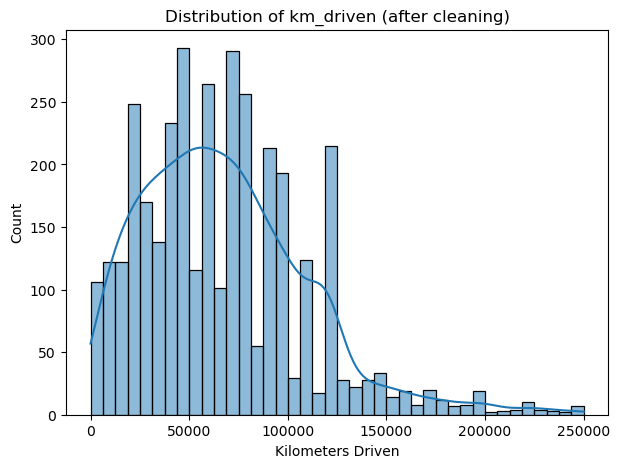

In [68]:
plt.figure(figsize=(7,5))
sns.histplot(df['km_driven'], bins=40, kde=True)
plt.xlabel("Kilometers Driven")
plt.title("Distribution of km_driven (after cleaning)")
plt.show()


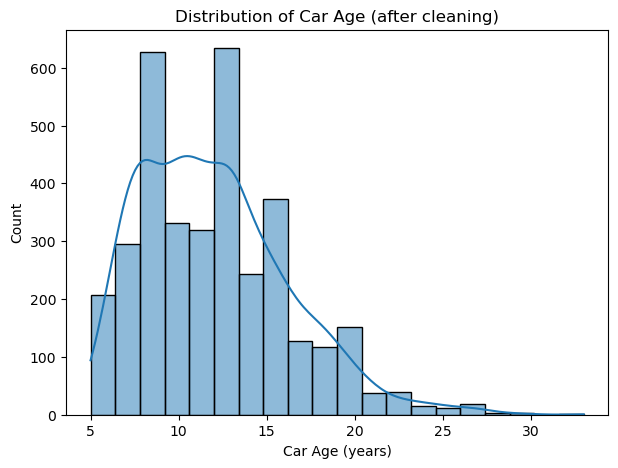

In [62]:
plt.figure(figsize=(7,5))
sns.histplot(df['car_age'], bins=20, kde=True)
plt.xlabel("Car Age (years)")
plt.title("Distribution of Car Age (after cleaning)")
plt.show()

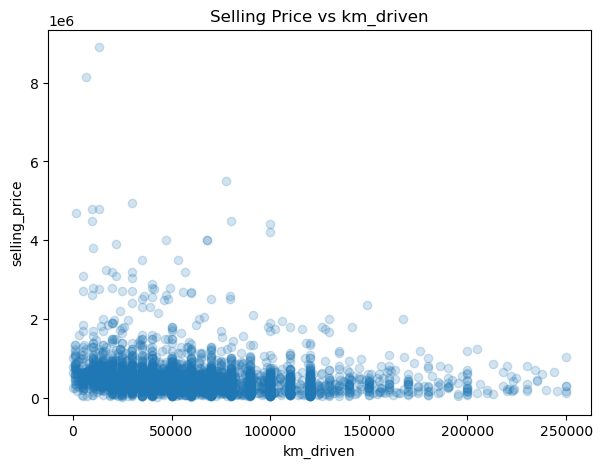

In [72]:
plt.figure(figsize=(7,5))
plt.scatter(df['km_driven'], df['selling_price'], alpha=0.2)
plt.xlabel("km_driven")
plt.ylabel("selling_price")
plt.title("Selling Price vs km_driven")
plt.show()

In [44]:
features = ['car_age', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner']
target = 'selling_price'
X = df[features].copy()
y = df[target].copy()

In [45]:
y_log = np.log1p(y)

In [54]:
numeric_features = ['car_age', 'km_driven']
numeric_transformer = StandardScaler()

In [47]:
categorical_features = ['fuel', 'seller_type', 'transmission', 'owner']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [48]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

gbr = GradientBoostingRegressor(random_state=42)

pipeline = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', gbr)
])

param_grid = {
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 4, 5]
}

param_dist = {
    'model__learning_rate': [0.01, 0.02, 0.05, 0.1],
    'model__n_estimators': [100, 150, 200, 300],
    'model__max_depth': [3, 4, 5],
}

SEARCH = 'random'

cv = KFold(n_splits=5, shuffle=True, random_state=42)

if SEARCH == 'grid':
    search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
elif SEARCH == 'random':
    from scipy.stats import randint
    search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=12,
                                cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, random_state=42)
else:
    pipeline.set_params(model__n_estimators=200, model__learning_rate=0.05, model__max_depth=4)
    search = pipeline


if SEARCH in ('grid', 'random'):
    print("Starting hyperparameter search (this can take from minutes to hours depending on your machine)...")
    search.fit(X, y_log)
    best_estimator = search.best_estimator_
    best_params = search.best_params_
    print("Best params:", best_params)
else:
    print("Training direct pipeline (no hyperparameter search)...")
    pipeline.fit(X, y_log)
    best_estimator = pipeline
    best_params = pipeline.get_params()


Starting hyperparameter search (this can take from minutes to hours depending on your machine)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.05}


5-fold CV RMSE: 362194.06
5-fold CV R^2: 0.4961


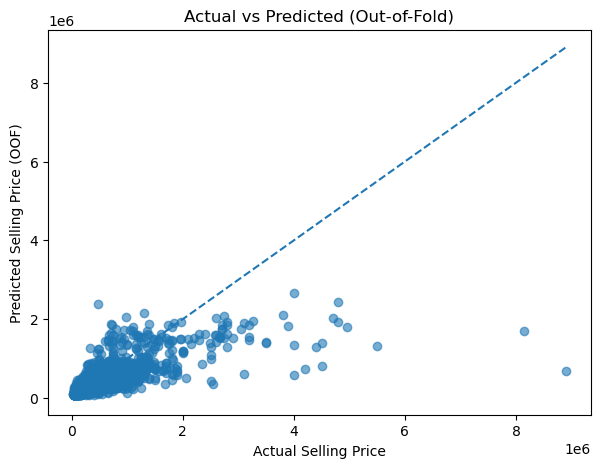

In [49]:
oof_pred_log = cross_val_predict(best_estimator, X, y_log, cv=cv, n_jobs=-1)
oof_pred = np.expm1(oof_pred_log)

rmse = np.sqrt(mean_squared_error(y, oof_pred))
r2 = r2_score(y, oof_pred)
print(f"5-fold CV RMSE: {rmse:.2f}")
print(f"5-fold CV R^2: {r2:.4f}")

plt.figure(figsize=(7,5))
plt.scatter(y, oof_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], linestyle='--')
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price (OOF)")
plt.title("Actual vs Predicted (Out-of-Fold)")
plt.show()



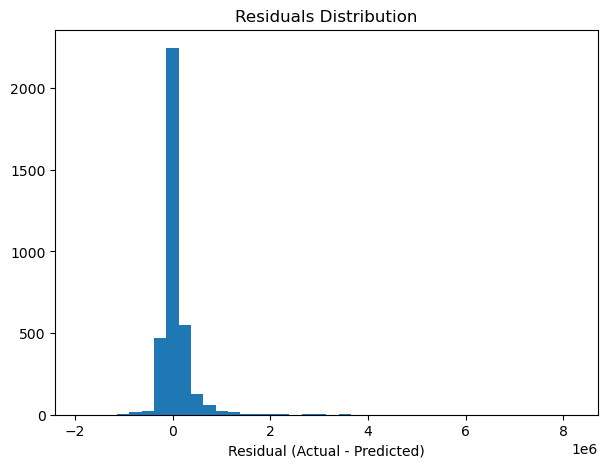

In [50]:
residuals = y - oof_pred
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=40)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residuals Distribution")
plt.show()

In [51]:
ohe = best_estimator.named_steps['pre'].named_transformers_['cat']
num_names = numeric_features
cat_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = num_names + cat_names
importances = best_estimator.named_steps['model'].feature_importances_
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
print("Top features:\n", fi_df.head(15))


Top features:
                          feature  importance
0                        car_age    0.681976
3                    fuel_Diesel    0.134791
10        transmission_Automatic    0.069541
11           transmission_Manual    0.062173
1                      km_driven    0.025839
8         seller_type_Individual    0.013808
6                    fuel_Petrol    0.005169
7             seller_type_Dealer    0.002040
12             owner_First Owner    0.001332
13    owner_Fourth & Above Owner    0.001013
16             owner_Third Owner    0.000934
9   seller_type_Trustmark Dealer    0.000756
14            owner_Second Owner    0.000441
15          owner_Test Drive Car    0.000187
5                       fuel_LPG    0.000000


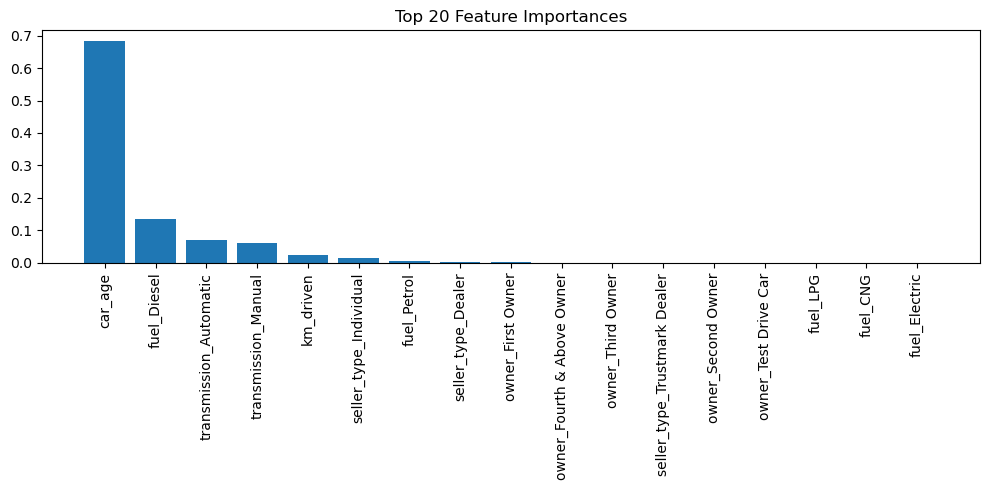

In [52]:
plt.figure(figsize=(10,5))
plt.bar(fi_df['feature'][:20], fi_df['importance'][:20])
plt.xticks(rotation=90)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


In [53]:
MODEL_OUT = "gbr_car_price_model.joblib"
joblib.dump(best_estimator, MODEL_OUT)
print("Model saved to:", MODEL_OUT)

Model saved to: gbr_car_price_model.joblib


0       18
1       18
2       13
3        8
4       11
        ..
4335    11
4336    11
4337    16
4338     9
4339     9
Name: car_age, Length: 3559, dtype: int64 0        70000
1        50000
2       100000
3        46000
4       141000
         ...  
4335     80000
4336     80000
4337     83000
4338     90000
4339     40000
Name: km_driven, Length: 3559, dtype: int64
